<a href="https://colab.research.google.com/github/theresamvlr/mobilenetv3-indo-food/blob/main/Tesis_Januari_MobileNetV3Large.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Changing CPU to GPU

In [ ]:
# !nvidia-smi

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()
# Standard output is '/device:GPU:0' - testing whether tensorflow can use GPU

'/device:GPU:0'

#Importing MobileNetV3Large library

In [ ]:
from keras.applications.mobilenet_v3 import MobileNetV3Large

#Initiate the model as MobileNetV3Large

By specifying weights='imagenet', you indicate that you want the network to be pretrained with ImageNet.

In [ ]:
model = MobileNetV3Large(weights='imagenet')

#Import libraries yang I still dunno which one is needed but yea

In [ ]:
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications.mobilenet_v3 import preprocess_input
import numpy as np
from IPython.display import Image
import keras.optimizers 
from keras import utils

data augmentation
should see the website here https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

also great article dispelling myths about data augmentation https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/ 

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb#scrollTo=qJdpyqK541ty mau coba pake ini buat jalanin augmentation nya. tpi sebelumnya harus di split dlu yang training, validating dan testing.

or see the youtub Kirsh Naik

#Initial MobileNetV3Large architecture

In [ ]:
print(model.summary())

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                

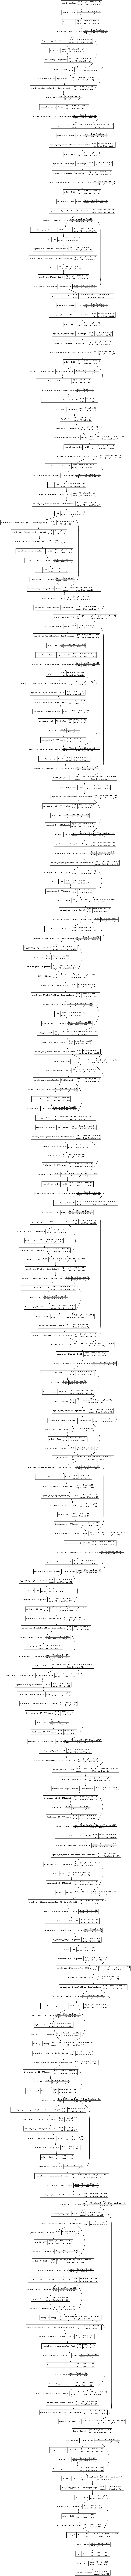

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



#My Proposed Architecture - modified MobileNetV3Large

freezing feature extraction, only unfreezing the classifier

GlobalAveragePooling2d vs Flatten : 
That both seem to work doesn't mean they do the same.

Flatten will take a tensor of any shape and transform it into a one dimensional tensor (plus the samples dimension) but keeping all values in the tensor. For example a tensor (samples, 10, 20, 1) will be flattened to (samples, 10 * 20 * 1).

GlobalAveragePooling2D does something different. It applies average pooling on the spatial dimensions until each spatial dimension is one, and leaves other dimensions unchanged. In this case values are not kept as they are averaged. For example a tensor (samples, 10, 20, 1) would be output as (samples, 1, 1, 1), assuming the 2nd and 3rd dimensions were spatial (channels last).

##making my model

In [ ]:

from keras.layers import Flatten

base_model=MobileNetV3Large(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
x=Flatten()(x)

preds=Dense(5,activation='softmax')(x) #final layer with softmax activation, pake nya 5 karena cuma ada 5 kelas to classify

In [ ]:


model=Model(inputs=base_model.input,outputs=preds)
#specifying input and output. now a model has been created based on our architecture.

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling_1[0][0]']            
                                16)                                                           

##another method to transfer learning: 
me copying the code from here https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299 exactly. i think dia nge freeze only the first 20 layers? 

#Augmenting the training datas

https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/ i think this is okay?

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

training set

In [ ]:
#make sure you provide the same target size as initialised for the image size
train_path = '/content/drive/MyDrive/UNIVERSITY/Masters/Thesis/dataset/train'

training_set = train_datagen.flow_from_directory(train_path, 
                                                 target_size = (224, 224),
                                                 batch_size = 1,
                                                 class_mode = 'categorical')

Found 7274 images belonging to 5 classes.


validation set

In [ ]:
valid_path = '/content/drive/MyDrive/UNIVERSITY/Masters/Thesis/dataset/valid'

valid_set = valid_datagen.flow_from_directory(valid_path, 
                                                 target_size = (224, 224),
                                                 batch_size = 1,
                                                 class_mode = 'categorical')

Found 902 images belonging to 5 classes.


test set

In [ ]:

test_path = '/content/drive/MyDrive/UNIVERSITY/Masters/Thesis/dataset/test'

test_set = test_datagen.flow_from_directory(test_path, 
                                                 target_size = (224, 224),
                                                 batch_size = 1,
                                                 class_mode = 'categorical')

Found 913 images belonging to 5 classes.


#Training the model with the dataset

Now lets load the training data into the ImageDataGenerator. Specify path, and it automatically sends the data for training in batches, simplifying the code.

https://www.youtube.com/watch?v=chQNuV9B-Rw&ab_channel=KrishNaik ini ngajarin caranya train pake own data untuk image classification

#compiling the model

In [ ]:
len(training_set)

7274

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=len(training_set)//training_set.batch_size

model.fit_generator(training_set,
                    validation_data = valid_set,
                   epochs=10,
                   steps_per_epoch=step_size_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/10


UnknownError: ignored